# Dealing with spectra stacks objects

This is to deal with the new feature from Attolight software (Jan 2021).

In [1]:
%matplotlib qt
import os, glob
import numpy as np
import pandas as pd
import lumispy as lum

In [20]:
bkg_substracted = True
overwrite_processed_files = False

# PARAMS
root = os.path.abspath(r'F:\HYPCards_PROD')
session = os.path.relpath(r'20220630-JORDI')
stacks_folder = 'SPECTRAS'

file_end = '*V-B.txt' if bkg_substracted else '*V.txt'

In [21]:
# Create the 2 directories necessary to store files

p1 = os.path.join(root, session, stacks_folder, 'processed_to_df')
p2 = os.path.join(root, session, stacks_folder, 'plots')

try:
    os.mkdir(p1)
    os.mkdir(p2)
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directories")

Creation of the directory failed


In [22]:
# Load with the time axis
for base, dirs, _ in os.walk(os.path.join(root, session, stacks_folder)):
    for dir in dirs[:]:
        # Ignore these 2 folders... do no look for raw files in here.
        if dir in ['processed_to_df', 'plots']:
            continue
        else:
            s = '-time-B.csv' if bkg_substracted else '-time.csv'
            save_path = os.path.join(base, 'processed_to_df', dir+s)
            
            # Skip if file has already been processed
            if os.path.exists(save_path) and not overwrite_processed_files:
                continue
            
            status_file  = os.path.join(base, dir, 'MicroscopeStatus.txt')
            with open(status_file, encoding='windows-1252') as status:
                for line in status:
                    if 'exposureTime' in line:
                        exp_t_s = float(line.split(':')[1])

            generic_path = os.path.join(base, dir, file_end)
            files = [p for p in glob.glob(generic_path,recursive=True)]
            files = sorted(files)
            x = np.loadtxt(files[0])[:,0]

            df = pd.DataFrame(x, columns=['x_nm'])
            for i,f in enumerate(files):

                df['{}'.format((i+1)*exp_t_s)] = np.loadtxt(f)[:,1]

            # Remove spikes
            dat = df.iloc[:,1:].values.transpose()
            cl = lum.signals.CLSpectrum(dat)
            cl.remove_spikes(inplace=True)

            dat = cl.data
            dat = np.vstack([x, dat]).transpose()
            df_corrected = pd.DataFrame(dat, columns=df.columns)
            df_corrected

            df_corrected.to_csv(save_path, index=False)

            print(dir+s)

#  Plot the results

In [23]:
%matplotlib qt
import os, glob
import lumispy as lum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import addcopyfighandler

In [24]:
# PARAMS
# root = os.path.abspath('G:\My Drive\PhD\projects\external_measurements')
# session = os.path.relpath(r'20220118-CsAgBiBr3_2D_3D_films')
stacks_folder = 'SPECTRAS'

file_end = '*time-B.csv' if bkg_substracted else '*-time.csv'

path = os.path.join(root, session, stacks_folder, 'processed_to_df', file_end)
files = [p for p in glob.glob(path,recursive=True)]
[('i={}'.format(i), os.path.basename(f)) for i,f in enumerate(files)]

[('i=0', 'SPECTRAS-1-time-B.csv'),
 ('i=1', 'SPECTRAS-2-time-B.csv'),
 ('i=2', 'SPECTRAS-3-time-B.csv'),
 ('i=3', 'SPECTRAS-4-time-B.csv'),
 ('i=4', 'SPECTRAS-5-time-B.csv'),
 ('i=5', 'SPECTRAS-6-time-B.csv'),
 ('i=6', 'SPECTRAS-7-time-B.csv'),
 ('i=7', 'SPECTRAS-8-time-B.csv'),
 ('i=8', 'SPECTRAS-9-time-B.csv')]

Select one of the files to plot

C:\ProgramData\Miniconda3\envs\lumispy\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


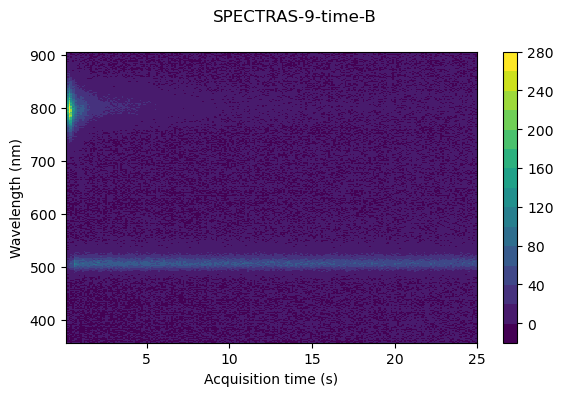

In [25]:
def plot_contour_of_stack_dp(csv_file, nbins=15, cmap='viridis', figsize=(6,4)):

    scan_name = os.path.basename(csv_file).split('.')[0]

    df = pd.read_csv(csv_file)
    x = df['x_nm']
    df.pop('x_nm')
    skip_t = 0
    df = df.iloc[:,skip_t:]
    t = np.array(list(df.columns), dtype='float32')
    t_diff = t[1] - t[0]
    if t[0] != 0:
        t_subtract = skip_t * t_diff
        t = t - t_subtract
    dat = df.to_numpy()
    
    vmin = np.quantile(dat, q=0.0001)
    vmax = np.quantile(dat, q=0.9999)
    X, Y = np.meshgrid(t,x)

    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    levels = MaxNLocator(nbins=nbins).tick_values(vmin, vmax)
    cmap = plt.get_cmap(cmap)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    f, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(X, Y, dat, cmap=cmap, norm=norm)
    f.colorbar(im, ax=ax)
    ax.set_ylabel("Wavelength (nm)")
    ax.set_xlabel("Acquisition time (s)")
    f.suptitle(scan_name)
    plt.tight_layout()
    return f

plot_contour_of_stack_dp(files[-1])

In [26]:
for f in files[:]:
    fig = plot_contour_of_stack_dp(f)
    name = os.path.basename(f).split('.')[0] + '.png'
    path = os.path.join(root, session, stacks_folder, 'plots', name)
    plt.savefig(path)
    plt.close()

C:\ProgramData\Miniconda3\envs\lumispy\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [37]:
# Plot spectra evolution on 1D plot

def plot_lineplot_of_stack_dp(csv_file, cmap='viridis', figsize=(6,4), normalise=False, xlim=None):

    scan_name = os.path.basename(csv_file).split('.')[0]

    df = pd.read_csv(csv_file)

    # Normalise data
    if normalise:
        df_norm = df.iloc[:,1:]
        df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())
        df = pd.concat([df.iloc[:,0], df_norm], axis=1)

    # Melt dataframe to have lines
    df = df.melt('x_nm', var_name='ts',  value_name='ys')
    df = df.astype('float')

    import seaborn as sns
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x="x_nm", y="ys", hue='ts', data=df, legend='brief', ax=ax, palette=cmap)


    ax.set_ylabel("Intensity (a.u.)")
    ax.set_xlabel("Wavelength (nm)")
    if xlim is not None:
        ax.set_xlim(xlim)
    f.suptitle(scan_name)
    plt.legend(loc='upper left')
    plt.tight_layout()
    return f

plot_lineplot_of_stack_dp(files[-1]), plot_lineplot_of_stack_dp(files[-1], normalise=True)

(<Figure size 600x400 with 1 Axes>, <Figure size 600x400 with 1 Axes>)